# Example 002 - estimate SIM performance using Argolight SIM v1 test target slide
  
Test targets with known ground truth and a variety of pattern orientations are useful to estimate the overall quality of the SIM instrument and reconstruction. Here, we use an [Argolight SIM v1 slide](https://argolight.com/files/Argo-SIM/Argo-SIM-v1.1_User-guide.pdf) with sets of lines that are spaced from 0 to 390 nm apart. The line spacing changes in 30 nm increments.

### Import libraries.

In [20]:
import napari
import numpy as np
from numpy import fft
import pickle
import tifffile
from pathlib import Path
import mcsim.analysis.sim_reconstruction as sim
import localize_psf.fit_psf as psf
import localize_psf.affine as affine
import localize_psf.rois as rois
from mcsim.analysis import analysis_tools
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

### Load experimental data containing all wavelengths and patterns.

In [4]:
ncolors = 2
nangles = 3
nphases = 3
nx = 2048
ny = 2048
imgs = tifffile.imread(Path("data", "example_002", "raw_data", "argosim_line_pairs.tif")).reshape([ncolors, nangles, nphases, ny, nx])

### Set experimental metadata.

In [5]:
na = 1.3
pixel_size = 0.065
excitation_wavelengths = [0.465, 0.532]
emission_wavelengths = [0.519, 0.580]

### View data in Napari

In [ ]:
viewer = napari.view_image(imgs[0,:],name='em: 520 nm',scale=(pixel_size,pixel_size))
viewer.add_image(imgs[1,:],name='em: 580 nm',scale=(pixel_size,pixel_size))
viewer.scale_bar.unit='um'
viewer.scale_bar.visible=True

### Crop image to ROI containing Argolight test target.

In [6]:
roi = rois.get_centered_roi([791, 896], [850, 850])
nx_roi = roi[3] - roi[2]
ny_roi = roi[1] - roi[0]

## SIM reconstruction using calibrated instrument parameters 

### Load experimental optical transfer function.

In [7]:
otf_data_path = Path("data", "example_002", "calibration", "2020_05_19_otf_fit_blue.pkl")

with open(otf_data_path, 'rb') as f:
    otf_data = pickle.load(f)
otf_p = otf_data['fit_params']

otf_fn = lambda f, fmax: 1 / (1 + (f / fmax * otf_p[0]) ** 2) * psf.circ_aperture_otf(f, 0, na, 2 * na / fmax)

### Load pre-calculated affine transforms for qi2lab DMD-SIM.

In [9]:
affine_fnames = [Path("data", "example_002", "calibration", "2021-02-03_09;43;06_affine_xform_blue_z=0.pkl"),
                 Path("data", "example_002", "calibration", "2021-02-03_09;43;06_affine_xform_green_z=0.pkl")]

affine_xforms = []
for p in affine_fnames:
    with open(p, 'rb') as f:
        affine_xforms.append(pickle.load(f)['affine_xform'])

### Load qi2lab DMD-SIM patterns. Estimate frequency and phase using extracted affine transforms.

In [33]:
dmd_pattern_data_fpath = [Path("data", "example_002", "calibration", "sim_patterns_period=6.01_nangles=3.pkl"),
                          Path("data", "example_002", "calibration", "sim_patterns_period=6.82_nangles=3.pkl")]

frqs_dmd = np.zeros((2, 3, 2))
phases_dmd = np.zeros((ncolors, nangles, nphases))
for kk in range(ncolors):
    ppath = dmd_pattern_data_fpath[kk]
    xform = affine_xforms[kk]

    with open(ppath, 'rb') as f:
        pattern_data = pickle.load(f)

    # DMD intensity frequency and phase (twice electric field frq/phase)
    frqs_dmd[kk] = 2 * pattern_data['frqs']
    phases_dmd[kk] = 2 * pattern_data['phases']
    dmd_nx = pattern_data['nx']
    dmd_ny = pattern_data['ny']

for kk in range(1):
    # otf matrix
    fmax = 1 / (0.5 * emission_wavelengths[kk] / na)
    fx = fft.fftshift(fft.fftfreq(nx_roi, pixel_size))
    fy = fft.fftshift(fft.fftfreq(ny_roi, pixel_size))
    ff = np.sqrt(fx[None, :] ** 2 + fy[:, None] ** 2)
    otf = otf_fn(ff, fmax)
    otf[ff >= fmax] = 0

    # guess frequencies/phases
    frqs_guess = np.zeros((nangles, 2))
    phases_guess = np.zeros((nangles, nphases))
    for ii in range(nangles):
        for jj in range(nphases):
            # estimate frequencies based on affine_xform
            frqs_guess[ii, 0], frqs_guess[ii, 1], phases_guess[ii, jj] = \
                affine.xform_sinusoid_params_roi(frqs_dmd[kk, ii, 0], frqs_dmd[kk, ii, 1],
                                                 phases_dmd[kk, ii, jj], [dmd_ny, dmd_nx], roi, xform)

    # convert from 1/mirrors to 1/um
    frqs_guess = frqs_guess / pixel_size

### Perform SIM reconstruction using known OTF and plot results.

In [34]:
%matplotlib inline
imgset = sim.SimImageSet({"pixel_size": pixel_size, "na": na, "wavelength": emission_wavelengths[0]},
                        imgs[0, :, :, roi[0]:roi[1], roi[2]:roi[3]],
                        frq_estimation_mode="band-correlation",
                        frq_guess=frqs_guess,
                        phases_guess=phases_guess,
                        phase_estimation_mode="wicker-iterative",
                        combine_bands_mode="fairSIM",
                        fmax_exclude_band0=0.4, 
                        normalize_histograms=True,
                        otf=otf,
                        wiener_parameter=0.1,
                        background=100, 
                        gain=2, 
                        min_p2nr=0.5,
                        save_dir=Path("data","example_002","reconstruction"),
                        interactive_plotting=False, 
                        figsize=(20, 13))

imgset.reconstruct()
imgset.plot_figs()
imgset.save_imgs()
imgset.log_file.close()

wf_images = imgset.widefield
SR_images = imgset.sim_sr

del imgset

####################################################################################
2022/04/29 18:46:17
####################################################################################
Normalizing histograms took 0.74s
FT images took 0.49s
Computing widefield image took 0.33s
Computing SIM-OS image took 0.13s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.6s finished


estimating 3 frequencies took 11.16s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.27s
estimated modulation-contrast-to-noise ratio in 0.41s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s finished


estimated 9 phases in 7.51s using mode 'wicker-iterative'
separated bands in 0.11s
estimated noise in 0.23s
shifted bands in 3.09s
shifted otfs in 0.66s
estimated global phases and mod depths in 0.72s
computed band weights in 1.66s
combining bands using mode 'fairSIM' and Wiener parameter 0.100 took 1.42s
Deconvolved widefield in 0.79s
SIM reconstruction for 3 angles and 3 phases
images are size 850x850 with pixel size 0.065um
emission wavelength=519nm and NA=1.30
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.40 from bands around centers
wiener parameter = 0.10
################ Angle 0 ################
relative intensity to max angle = 0.835
phase relative intensities = 0.991, 1.000, 0.994, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 107.326, 105.557, 104.274
modulation depth = 0.683
Frequency guess= (-3.23450, -1.94043), period=265.118nm, angle=-149.040deg
Frequency fit  = (-3.23583, -1.93

### Display results

In [24]:
colormaps = ['bop blue', 'bop orange']

viewer = napari.view_image(wf_images,name='Widefield',scale=(pixel_size,pixel_size),colormap = colormaps[0],blending='additive')
viewer.add_image(SR_images,name='SR',scale=(pixel_size/2,pixel_size/2),colormap = colormaps[1],blending='additive')

viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

Exception in callback BaseAsyncIOLoop._handle_events(6604, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(6604, 1)>
Traceback (most recent call last):
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\zmq\eventloop\zmqstream.py", line 452, in _handle_events
    self._handle_recv()
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\zmq\eventloop\zmqstream.py", line 481, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\jupyter_client\threaded.

## Importance of SLM calibration

### Calculate FFT of raw data to find frequency guesses

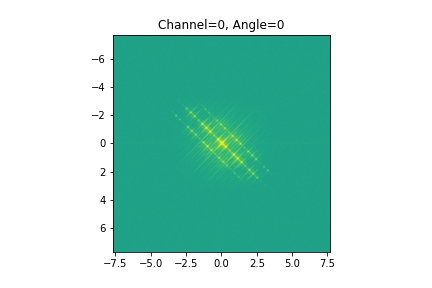

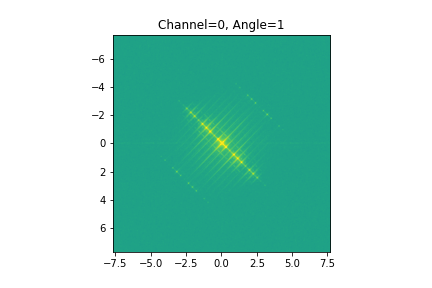

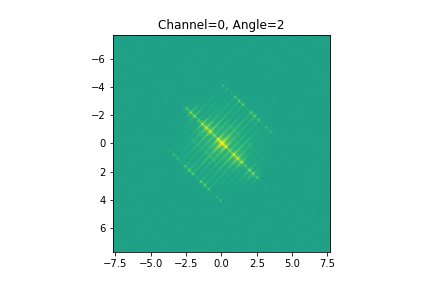

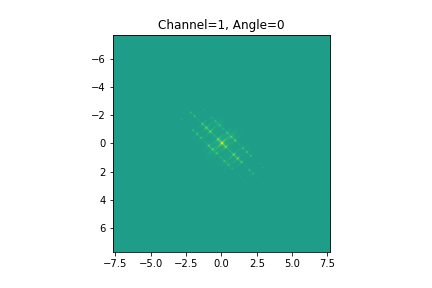

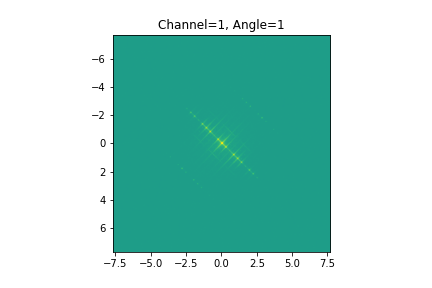

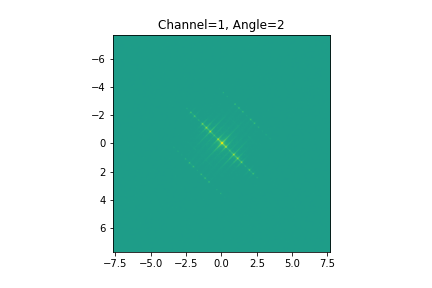

In [21]:
%matplotlib widget
for ch_idx in range(ncolors):

    image_set = imgs[ch_idx,:,:,:,:]

    dx = pixel_size
    fxs = analysis_tools.get_fft_frqs(nx, dx)
    df = fxs[1] - fxs[0]
    fys = analysis_tools.get_fft_frqs(ny, dx)
    ff = np.sqrt(np.expand_dims(fxs, axis=0)**2 + np.expand_dims(fys, axis=1)**2)
    for ii in range(image_set.shape[0]):
        ft = fft.fftshift(fft.fft2(fft.ifftshift(np.squeeze(image_set[ii, 0, :]))))

        figh = plt.figure()
        plt.title('Channel='+str(ch_idx)+", Angle="+str(ii))
        plt.imshow(np.abs(ft), norm=PowerNorm(gamma=0.1,vmin=65,vmax=1.5e7),
                    extent=[fxs[0] - 0.5 * df, fxs[-1] + 0.5 * df, fys[-1] + 0.5 * df, fys[0] - 0.5 * df])
        plt.show()